In [1]:
# tell Python to use the ecco_v4_py in the 'ECCOv4-py' repository
from os.path import join,expanduser
import sys

# identify user's home directory
user_home_dir = expanduser('~')

# import the ECCOv4 py library 
sys.path.insert(0,join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco

from scipy.stats import linregress
import fsspec
import zarr

import botocore  
import boto3
from boto3.session import Session
import cmocean
from collections import Counter
from dask.distributed import Client
import datetime
import fsspec
from gc import get_referents
import json
import numpy as np
from pathlib import Path
from pprint import pprint
import requests
import s3fs
import sys
from sys import getsizeof
import time as time
from types import ModuleType, FunctionType
import xarray as xr
import matplotlib.pyplot as plt
import zarr

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

#-------------------------------------------------------------------------|
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Use this for the netcdf files stored on an s3 bucket
def get_credentials(use_earthdata=False):
    """
    This routine automatically pulls your EDL crediential from .netrc file and use it to obtain an AWS S3 credential 
    through a PO.DAAC service accessible at https://archive.podaac.earthdata.nasa.gov/s3credentials.
    From the PO.DAAC Github (https://podaac.github.io/tutorials/external/July_2022_Earthdata_Webinar.html).
    
    Returns:
    =======
    
    credentials: a dictionary with AWS secret_key, access_key, and token
    """
    # NASA EarthData hosts ECCO V4r4 fileds
    if use_earthdata == False:
        session = boto3.Session()
        credentials_b3 = session.get_credentials()
        creds_b3 = credentials_b3.get_frozen_credentials()
        
        credentials = dict()
        credentials['secretAccessKey'] = credentials_b3.secret_key
        credentials['accessKeyId'] = credentials_b3.access_key
        credentials['sessionToken'] = credentials_b3.token

    # A 'public' AWS s3 bucket hosts V4r5 fields (they will eventually move to PO.DAAC)
    else:
        credentials = requests.get('https://archive.podaac.earthdata.nasa.gov/s3credentials').json()
    
    return credentials
    

In [3]:
def init_S3FileSystem(use_earthdata=False, requester_pays=True):
    """
    This routine automatically creates an 's3 file system' object and credentials dictionary.
    The s3 file system needs to be initialized with the special aws credentials.
    
    Returns:
    =======
    
    s3: an AWS S3 filesystem, 
    credentials: a dictionary with AWS secret_key, access_key, and token

    """
    credentials = get_credentials(use_earthdata=use_earthdata)

    if use_earthdata:
        requester_pays = False
        
    s3 = s3fs.S3FileSystem(requester_pays=requester_pays,
                           anon=False,
                           key=credentials['accessKeyId'],
                           secret=credentials['secretAccessKey'], 
                           token=credentials['sessionToken'])
    
    return s3, credentials

In [4]:
# function for determining the memory footprint of an object

# ... from https://stackoverflow.com/questions/449560/how-do-i-determine-the-size-of-an-object-in-python

# Custom objects know their class.
# Function objects seem to know way too much, including modules.
# Exclude modules as well.
BLACKLIST = type, ModuleType, FunctionType

def getsize(obj):
    """
    This routine returns the in-memory size of an python object
    
    Returns:
    =======
    
    size: size of object & members.
    """
    if isinstance(obj, BLACKLIST):
        raise TypeError('getsize() does not take argument of type: '+ str(type(obj)))
    seen_ids = set()
    size = 0
    objects = [obj]
    while objects:
        need_referents = []
        for obj in objects:
            if not isinstance(obj, BLACKLIST) and id(obj) not in seen_ids:
                seen_ids.add(id(obj))
                size += sys.getsizeof(obj)
                need_referents.append(obj)
        objects = get_referents(*need_referents)
    return size

# Loading SSH dataset from ECCO

In [5]:
# local path to monthly-mean native grid datasets
ecco_v4r5_mon_mean_native_dir = Path('/efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/')

# list sub-directories (one per dataset)
ecco_v4r5_mon_mean_native_dataset_paths = np.sort(list(ecco_v4r5_mon_mean_native_dir.glob('*')))

for i, d in enumerate(ecco_v4r5_mon_mean_native_dataset_paths):
    print(str(i).zfill(3),d)

000 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/ATM_SURFACE_TEMP_HUM_WIND_PRES
001 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/ICE_FRONT_FLUX
002 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/ICE_SHELF_FLUX
003 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_3D_MOMENTUM_ADV_TEND_X
004 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_3D_MOMENTUM_ADV_TEND_Y
005 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_3D_MOMENTUM_DISS_TEND_X
006 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_3D_MOMENTUM_DISS_TEND_Y
007 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_3D_MOMENTUM_TEND_X
008 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_3D_MOMENTUM_TEND_Y
009 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_AND_ICE_SURFACE_FW_FLUX
010 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_AND_ICE_SURFACE_HEAT_FLUX
011 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_AND_ICE_SURFACE_STRESS
012 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_BOLUS_STREAMFUNCTION
013 /efs_ecco/ECCO/V4/r5/netc

In [7]:
# Select a dataset (the one containing SSH)
dataset_num = 27

print('selected ', ecco_v4r5_mon_mean_native_dataset_paths[dataset_num])
TS_dataset_dir = ecco_v4r5_mon_mean_native_dataset_paths[dataset_num]

# make a list of all of the files in the directory
TS_dataset_files = np.sort(list(TS_dataset_dir.glob('*nc')))

# show first 5 files
print('\nFirst 5 files')
pprint([x.name for x in TS_dataset_files[:5]])


selected  /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/SEA_SURFACE_HEIGHT

First 5 files
['SEA_SURFACE_HEIGHT_mon_mean_1992-01_ECCO_V4r5_native_llc0090.nc',
 'SEA_SURFACE_HEIGHT_mon_mean_1992-02_ECCO_V4r5_native_llc0090.nc',
 'SEA_SURFACE_HEIGHT_mon_mean_1992-03_ECCO_V4r5_native_llc0090.nc',
 'SEA_SURFACE_HEIGHT_mon_mean_1992-04_ECCO_V4r5_native_llc0090.nc',
 'SEA_SURFACE_HEIGHT_mon_mean_1992-05_ECCO_V4r5_native_llc0090.nc']


# METHOD 3: “REFERENCE” LOADING FILES STORED ON AWS S3
## PART 1: V4R4 FILES ON PODAAC
## Find files
Kerchunk files on ecco-model-granules s3 bucket

In [8]:
s3, credentials = init_S3FileSystem(use_earthdata=False, requester_pays=True);

In [9]:
mzz_local_directory = Path('/efs_ecco/mzz-jsons-V4r5/MZZ_day_mean_native')
# different prefixes on s3
# MZZ_day_mean_latlon
# MZZ_day_mean_native
# MZZ_mon_mean_latlon
# MZZ_mon_mean_native
# MZZ_snap_native

In [10]:
# show they are on the local disk 
np.sort(list(mzz_local_directory.glob('*json')))

array([PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_day_mean_native/ATM_SURFACE_TEMP_HUM_WIND_PRES_day_mean_native_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_day_mean_native/ATM_SURFACE_TEMP_HUM_WIND_PRES_mon_mean_latlon_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_day_mean_native/OCEAN_AND_ICE_SURFACE_FW_FLUX_day_mean_native_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_day_mean_native/OCEAN_AND_ICE_SURFACE_FW_FLUX_mon_mean_latlon_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_day_mean_native/OCEAN_AND_ICE_SURFACE_HEAT_FLUX_day_mean_native_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_day_mean_native/OCEAN_AND_ICE_SURFACE_HEAT_FLUX_mon_mean_latlon_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_day_mean_native/OCEAN_AND_ICE_SURFACE_STRESS_day_mean_native_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_day_mean_native/O

In [1]:
# MZZ files have been downloaded. 
# select the SSH dataset
mzz_local_file= mzz_local_directory / 'SEA_SURFACE_HEIGHT_mon_mean_latlon_llc090_ECCOV4r5.json'
print(mzz_local_file)

NameError: name 'mzz_local_directory' is not defined

In [12]:

fs = fsspec.filesystem("reference",     
                       fo=str(mzz_local_file),
                       remote_protocol="s3",
                       remote_options={"anon":False, "requester_pays":True},
                       skip_instance_cache=True)
# 
fs.asynchronous = True
store = zarr.storage.FsspecStore(fs)
ds = xr.open_dataset(store, engine='zarr',
                     consolidated=False, chunks={'time':4, 'Z':50})

ds.time

<xarray.DataArray 'time' (time: 336)> Size: 3kB
array(['1992-01-16T18:00:00.000000000', '1992-02-15T12:00:00.000000000',
       '1992-03-16T12:00:00.000000000', ..., '2019-10-16T12:00:00.000000000',
       '2019-11-16T00:00:00.000000000', '2019-12-16T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 3kB 1992-01-16T18:00:00 ... 2019-12-16
Attributes:
    axis:                   T
    bounds:                 time_bnds
    comment:                 
    coverage_content_type:  coordinate
    long_name:              center time of averaging period
    standard_name:          time

## Time period selection: 1993/01/01 - 2017/12/31 => SSH_piseal


In [13]:
SSH_all = ds.SSH
lon_mg, lat_mg  = np.meshgrid(ds.longitude, ds.latitude)
# mean_SSH = ds.SSH.mean(dim='time').compute()

itime = ((ds.time >= np.array(datetime.datetime(1993,1,1)).astype('datetime64[s]')) & 
         (ds.time <= np.array(datetime.datetime(2017,12,31)).astype('datetime64[s]')))

In [14]:
SSH_piseal = SSH_all[itime,:,:]

In [15]:
SSH_piseal



<xarray.DataArray 'SSH' (time: 300, latitude: 360, longitude: 720)> Size: 311MB
dask.array<getitem, shape=(300, 360, 720), dtype=float32, chunksize=(4, 360, 720), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2kB 1993-01-16T12:00:00 ... 2017-12-16T1...
  * latitude   (latitude) float32 1kB -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float32 3kB -179.8 -179.2 -178.8 ... 179.2 179.8
Attributes:
    comment:                Also known as ocean dynamic sea level.  The local...
    coverage_content_type:  modelResult
    long_name:              Dynamic sea surface height
    units:                  m
    valid_max:              1.175236463546753
    valid_min:              -1.7391213178634644

In [16]:
SSH_piseal

<xarray.DataArray 'SSH' (time: 300, latitude: 360, longitude: 720)> Size: 311MB
dask.array<getitem, shape=(300, 360, 720), dtype=float32, chunksize=(4, 360, 720), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2kB 1993-01-16T12:00:00 ... 2017-12-16T1...
  * latitude   (latitude) float32 1kB -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float32 3kB -179.8 -179.2 -178.8 ... 179.2 179.8
Attributes:
    comment:                Also known as ocean dynamic sea level.  The local...
    coverage_content_type:  modelResult
    long_name:              Dynamic sea surface height
    units:                  m
    valid_max:              1.175236463546753
    valid_min:              -1.7391213178634644

In [32]:
poly = SSH_piseal.polyfit(dim='time',deg=1)
slope = poly.polyfit_coefficients.sel(degree=1)
slope = slope*12*1e3*2548800000000000
slope

<xarray.DataArray 'polyfit_coefficients' (latitude: 360, longitude: 720)> Size: 2MB
dask.array<mul, shape=(360, 720), dtype=float64, chunksize=(360, 720), chunktype=numpy.ndarray>
Coordinates:
    degree     int64 8B 1
  * longitude  (longitude) float32 3kB -179.8 -179.2 -178.8 ... 179.2 179.8
  * latitude   (latitude) float32 1kB -89.75 -89.25 -88.75 ... 88.75 89.25 89.75

In [33]:
a = SSH_piseal.time[1]-SSH_piseal.time[0]
np.array(a)

array(2548800000000000, dtype='timedelta64[ns]')

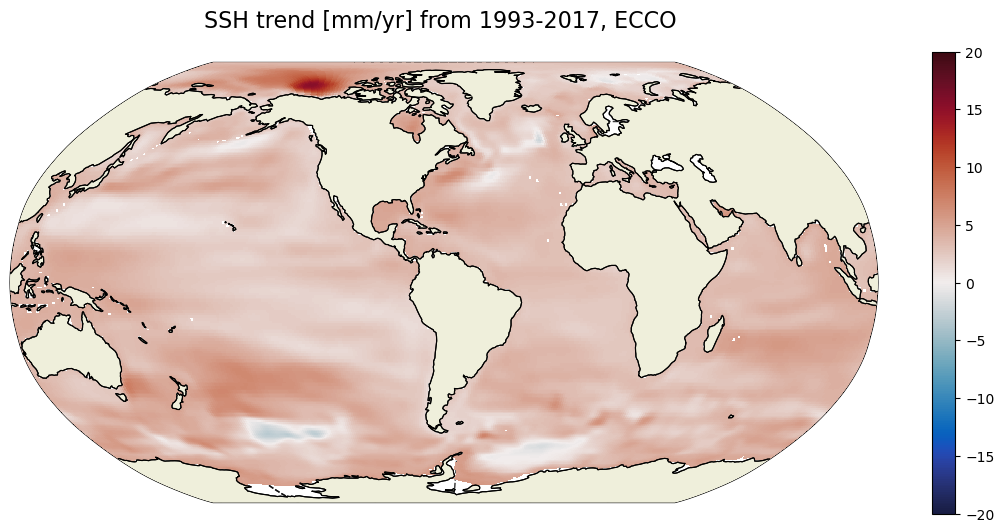

In [56]:
plt.figure(figsize=[14,6]);
ecco.plot_proj_to_latlon_grid(lon_mg,lat_mg,slope, 
                              user_lon_0=-67, show_colorbar=True,
                              show_grid_lines=True,
                              cmin=-20, cmax=20, 
                              cmap=cmocean.cm.balance);
plt.title('SSH trend [mm/yr] from 1993-2017, ECCO \n',fontsize=16)
# cbar2.set_label('[mm/yr]')
plt.savefig("/efs_ecco/ylu/ssh_trend_ECCO.png", dpi=600, bbox_inches='tight')


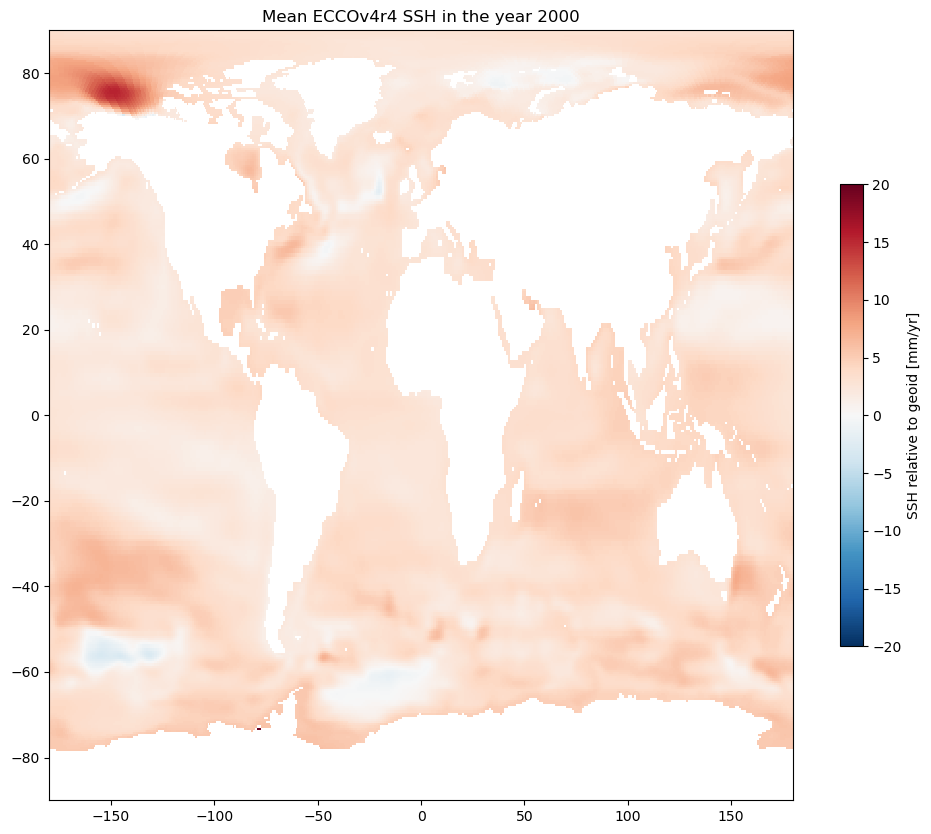

In [36]:
plt.figure(figsize=(12,10))
curr_plot = plt.pcolormesh(lon_mg, lat_mg, slope, cmap='RdBu_r', vmin=-20, vmax=20)
plt.colorbar(curr_plot,shrink=0.6,label='SSH relative to geoid [mm/yr]')
plt.title('Mean ECCOv4r4 SSH in the year 2000')
plt.show()

## Read the CMEMS data

In [46]:
help(ecco.plot_proj_to_latlon_grid)

Help on function plot_proj_to_latlon_grid in module ecco_v4_py.tile_plot_proj:

plot_proj_to_latlon_grid(lons, lats, data, projection_type='robin', dx=0.25, dy=0.25, mapping_method='nearest_neighbor', radius_of_influence=112000, plot_type='pcolormesh', circle_boundary=False, cmap=None, cmin=None, cmax=None, user_lon_0=0, user_lat_0=None, lat_lim=50, parallels=None, show_coastline=True, show_colorbar=False, show_land=True, show_grid_lines=True, show_grid_labels=False, show_coastline_over_data=True, show_land_over_data=True, grid_linewidth=1, grid_linestyle='--', colorbar_label=None, colorbar_location=None, subplot_grid=None, less_output=True, **kwargs)
    Plot a field of data from an arbitrary projection with lat/lon coordinates
    on a geographic projection after resampling it to a regular lat/lon grid.


    Parameters
    ----------
    lons, lats : numpy ndarray or xarray DataArrays, required
        the longitudes and latitudes of the data to plot

    data : numpy ndarray or xar